In [3]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.patches as patches
import pickle
import os
from scipy import stats

DATASET lx33, UUUT has no significant TF

In [146]:
#STEP 1: Which file to visualize network reconstruction

DATASET_ID = "lx33"
state = "UUUU"
frac_cells = 0.66

In [147]:
#STEP 1+: file path way
DATA_FOLDERNAME = "/home/linl5/project/SCLC/data/{}".format(DATASET_ID)
REGULONS_FNAME = os.path.join(DATA_FOLDERNAME, '{}.{}.{}.regulons.p'.format(DATASET_ID, state, frac_cells))
FIGURE_FOLDERNAME = "/home/linl5/project/SCLC/figures/{}".format(DATASET_ID)
IMPORTANT_TF_REGULON_DF_FILE = os.path.join(DATA_FOLDERNAME, '{}.{}.{}.important_tf.csv'.format(DATASET_ID, state, frac_cells))

In [148]:
#STEP 1++: reading in full tf list for human
#Downloaded fromm pySCENIC github repo: https://github.com/aertslab/pySCENIC/tree/master/resources Aug-1-2023
RESOURCES_FOLDERNAME = "/home/linl5/project/SCLC/resources"
HUMAN_TFS_FNAME = os.path.join(RESOURCES_FOLDERNAME, 'allTFs_hg38.txt')

# Read the file into a pandas Series
tf_series = pd.read_csv(HUMAN_TFS_FNAME, header=None)

# Convert the pandas Series to a Python list
tf_full_list = tf_series[0].to_list()

In [149]:
#STEP 2: reading regulon.p files and converting it to df with rank normalization
with open(REGULONS_FNAME, 'rb') as f:
    regulons = pickle.load(f)
# Initialize an empty list to store the rows of the new DataFrame
rows = []

# Loop through each regulon object in the list
for regulon in regulons:
    regulon_name = regulon.name
    transcription_factor = regulon.transcription_factor
    context = regulon.context
    score = regulon.score
    orthologous_identity = regulon.orthologous_identity
    similarity_qvalue = regulon.similarity_qvalue
    annotation = regulon.annotation
    nes = regulon.nes
    
    #Performing rank normalization: from histogram values appear to be postively skewed for most regulons
    values = list(regulon.gene2weight.values())
    rank_normalized_weight = stats.rankdata(values)/(len(values) + 1)
    count = 0
    # Loop through each gene in the regulon and extract gene-target pairs
    for gene, weight in regulon.gene2weight.items():
        row = {
            'Regulon_Name': regulon_name,
            'Transcription_Factor': transcription_factor,
            'Context': context,
            'Target_Gene': gene,
            'Weight': weight,
            'Scores': score,
            'nes': nes,
            'orthologous_identity': orthologous_identity,
            'similarity_qvalue': similarity_qvalue, 
            'annotation': annotation,
            'Rank_Norm' : rank_normalized_weight[count]
        }
        rows.append(row)
        count += 1

# Create a new DataFrame from the list of rows
regulon_df = pd.DataFrame(rows)
print("Successful Reading:", REGULONS_FNAME)
print("Shape of all regulon interactions: ", regulon_df.shape)
# visualizing df
regulon_df.head(5)

Successful Reading: /home/linl5/project/SCLC/data/lx33/lx33.UUUU.0.66.regulons.p
Shape of all regulon interactions:  (10910, 11)


,Regulon_Name,Transcription_Factor,Context,Target_Gene,Weight,Scores,nes,orthologous_identity,similarity_qvalue,annotation,Rank_Norm
0,ARID5B(+),ARID5B,"(activating, cisbp__M0110.png)",ARR3,1.822324,2.808753,0.0,0.0,0.0,,0.666667
1,ARID5B(+),ARID5B,"(activating, cisbp__M0110.png)",ARID5B,1.000000,2.808753,0.0,0.0,0.0,,0.333333
2,ASCL1(+),ASCL1,"(tfdimers__MD00222.png, activating)",SULF2,1.332718,3.227860,0.0,0.0,0.0,,0.200000
3,ASCL1(+),ASCL1,"(tfdimers__MD00222.png, activating)",ASCL1,1.000000,3.227860,0.0,0.0,0.0,,0.100000
4,ASCL1(+),ASCL1,"(tfdimers__MD00222.png, activating)",CXXC5,2.216842,3.227860,0.0,0.0,0.0,,0.300000


In [150]:
# STEP 3: creating df with important df only

count = 0

#import in list of important TF
imp_TF = ("NEUROD1", "ASCL1", "POU3F2", "YAP1", "FOXA2", "PLCG2", "NOTCH1")
rows = []

# Loop through each regulon object in the list and subselect for only important tf
for regulon in regulons:
    regulon_name = regulon.name
    transcription_factor = regulon.transcription_factor
    context = regulon.context
    score = regulon.score
    
    #Performing rank normalization: from histogram values appear to be postively skewed for most regulons
    values = list(regulon.gene2weight.values())
    rank_normalized_weight = stats.rankdata(values)/(len(values) + 1)
    count = 0
    # Loop through each gene in the regulon and extract gene-target pairs
    for gene, weight in regulon.gene2weight.items():
        row = {
            'Regulon_Name': regulon_name,
            'Transcription_Factor': transcription_factor,
            'Context': context,
            'Target_Gene': gene,
            'Weight': weight,
            'Scores': score,
            'Rank_Norm' : rank_normalized_weight[count],
        }
        count += 1
        if row['Transcription_Factor'] in imp_TF:
            rows.append(row)
# Create a new DataFrame from the list of rows
sig_regulon_df = pd.DataFrame(rows)
sig_regulon_df.to_csv(IMPORTANT_TF_REGULON_DF_FILE, index=False, sep='\t')
print("Complete Writing: ", IMPORTANT_TF_REGULON_DF_FILE)
if (sig_regulon_df.empty):
    print("DataFrame Empty", DATASET_ID, state, frac_cells, "has zero sig TF. DO NOT PROCEED!!")
else:
    print('\n',DATASET_ID, state, frac_cells, "has following TF:", regulon_df['Transcription_Factor'].unique().tolist())
    print('\n',DATASET_ID, state, frac_cells, "has following significant TF:", sig_regulon_df['Transcription_Factor'].unique().tolist())
    sig_regulon_df

Complete Writing:  /home/linl5/project/SCLC/data/lx33/lx33.UUUU.0.66.important_tf.csv

 lx33 UUUU 0.66 has following TF: ['ARID5B', 'ASCL1', 'ASCL2', 'ATF3', 'ATF5', 'ATOH7', 'BHLHE40', 'BHLHE41', 'BRCA1', 'CEBPB', 'CEBPD', 'CREB3L1', 'CREB5', 'DDIT3', 'DMBX1', 'E2F1', 'E2F7', 'E2F8', 'EGR1', 'EGR2', 'EGR3', 'EGR4', 'EMX2', 'EN1', 'FOS', 'FOSB', 'FOXL2', 'GATA2', 'GATA5', 'HES6', 'HEY2', 'HMGB2', 'HOXC12', 'IRX2', 'ISL1', 'JUN', 'JUNB', 'KLF2', 'KLF4', 'KLF6', 'LHX3', 'LHX4', 'LHX9', 'MAF', 'MAFB', 'MEF2C', 'MSX1', 'MYBL1', 'MYBL2', 'MYC', 'MYOD1', 'MYOG', 'NEUROD1', 'NFIX', 'NHLH1', 'NKX2-5', 'NKX6-2', 'NR3C1', 'NR4A1', 'NRL', 'PGAM2', 'PHOX2B', 'PIR', 'PITX1', 'POU2F2', 'POU3F1', 'RARG', 'RELB', 'RXRG', 'SHOX2', 'SIX1', 'SNAI1', 'SNAI2', 'SOX14', 'SOX5', 'SP4', 'SP5', 'SP8', 'TAGLN2', 'TFAP2B', 'TFF3', 'TGIF1', 'TLX3', 'VDR', 'WT1']

 lx33 UUUU 0.66 has following significant TF: ['ASCL1', 'NEUROD1']


SUCCESSFULLY WRITTEN: /home/linl5/project/SCLC/figures/lx33/Important TF Network_lx33_UUUU_0.66.png


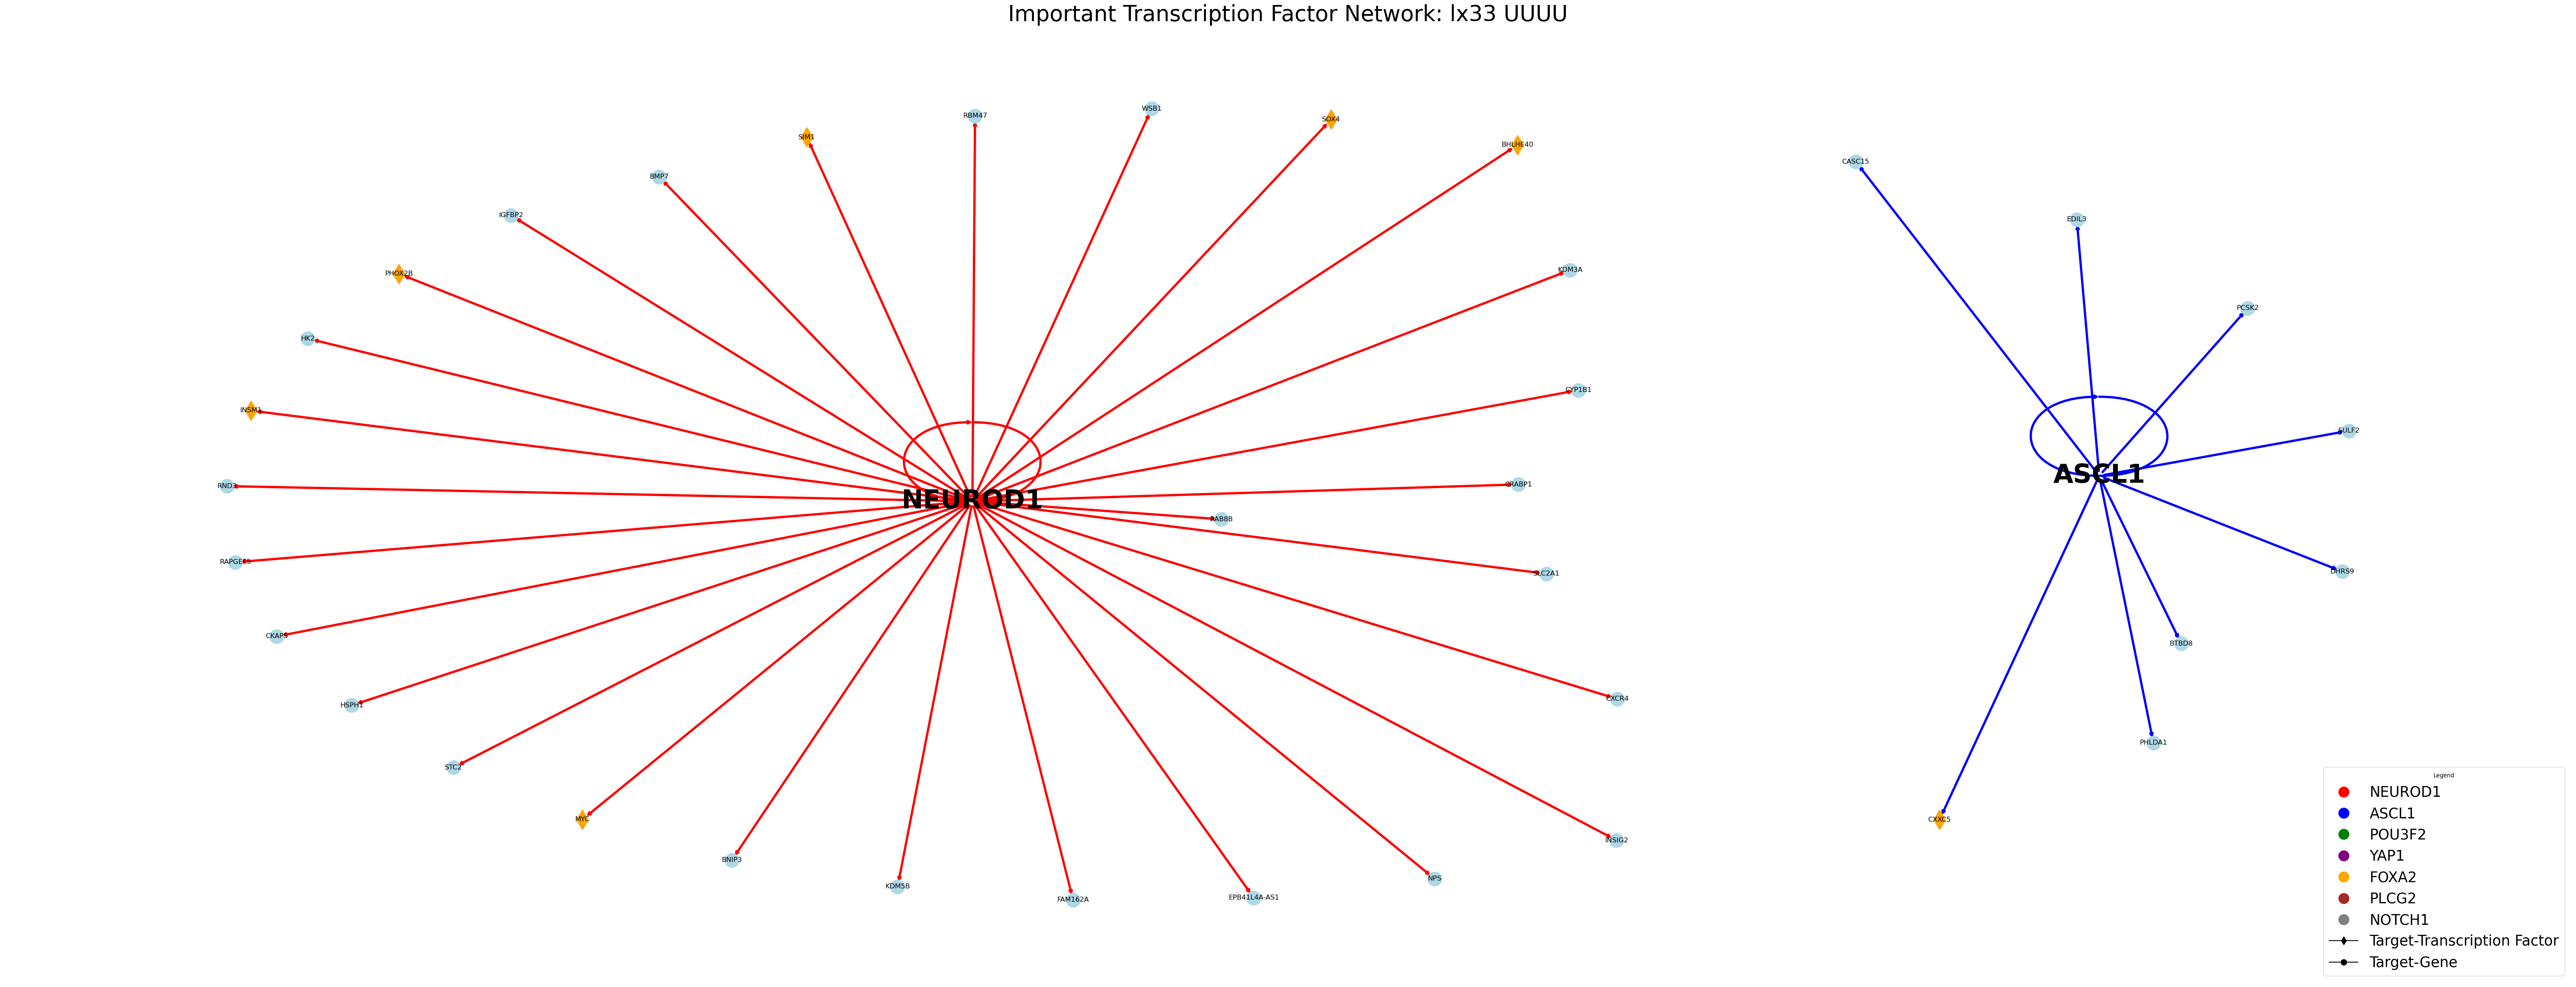

In [151]:
#STEP 4: NETWORK ANALYSIS: Building network based on the subset of important TF only

# Opening graph
grn = nx.MultiDiGraph()


#building nodes     
tg_list = sig_regulon_df['Target_Gene'].unique().tolist()
tf_list = sig_regulon_df['Transcription_Factor'].unique().tolist()
grn.add_nodes_from(tg_list, node_type='TG')
grn.add_nodes_from(tf_list, node_type='TF')


# Create a dictionary to hold subgraphs for each tf, meaning each tf has its own graph
regulon_subgraphs = {}

# Iterate through the DataFrame and add nodes and edges to the subgraphs
for _, row in sig_regulon_df.iterrows():
    regulon_name = row['Regulon_Name']
    tf = row['Transcription_Factor']
    tg = row['Target_Gene']
    weight = row['Rank_Norm']
    
    # Check if the tf subgraph already exists, if not, create it
    if regulon_name not in regulon_subgraphs:
        regulon_subgraphs[regulon_name] = nx.MultiDiGraph()
    
    # Add nodes and edges to the subgraph
    regulon_subgraphs[regulon_name].add_edge(tf, tg, weight=weight, regulon_name=regulon_name)

# Combine the subgraphs into a single graph, where we merge all nodes and edges of subgraph onto one
combined_graph = nx.MultiDiGraph()
for subgraph in regulon_subgraphs.values():
    combined_graph = nx.compose(combined_graph, subgraph)



# Calculate the angle between each subgraph based on the number of subgraphs: calculating posistions

num_subgraphs = len(regulon_subgraphs)
angle_between_subgraphs = 3 * np.pi / num_subgraphs #adjust how close the edges are to center of tf

# Create a dictionary to hold the positions of nodes and edges subgraphs: after applying a spring individual subgraph
subgraph_positions = {}

# Define the scale_factor and seperation factor
sep_factor = 30 #Adjust this value as needed !!! to seperate center of tf
scale_factor = 1  # Adjust this value as needed !!!

# Iterate through the subgraphs and calculate positions on a circle
for idx, (regulon_name, subgraph) in enumerate(regulon_subgraphs.items()):
    angle = idx * angle_between_subgraphs
    x = np.cos(angle) * scale_factor
    y = np.sin(angle) * scale_factor
    subgraph_positions[regulon_name] = (x + random.randint(3,sep_factor), y) #adjust!!!

# Create a dictionary to hold the positions of nodes in the combined graph -> secondary spring layout between subgraph to prevent edge intersection between subgraph
pos = {}

# Iterate through each subgraph and update positions for nodes
for regulon_name, subgraph in regulon_subgraphs.items():
    subgraph_pos = nx.spring_layout(subgraph, seed=42)
    
    # Scale the positions of nodes in the subgraph
    for node, coords in subgraph_pos.items():
        scaled_x = coords[0] * scale_factor + subgraph_positions[regulon_name][0]
        scaled_y = coords[1] * scale_factor + subgraph_positions[regulon_name][1]
        subgraph_pos[node] = (scaled_x, scaled_y)
    
    # Update the positions dictionary with the scaled positions
    pos.update(subgraph_pos)

    
# Calculate the combined layout by averaging node positions
combined_layout = nx.spring_layout(combined_graph, pos=pos, seed=42)

# Create a dictionary to map regulon names to unique edge colors
tf_edge_colors = {"NEUROD1":'red', "ASCL1":'blue', "POU3F2":'green', "YAP1":'purple', "FOXA2":'orange', "PLCG2":'brown', "NOTCH1":'gray'}


# Draw edges with unique colors for each regulon
# Iterate through edges and assign colors based on transcription factors
edge_colors = []

for u, v, data in combined_graph.edges(data=True):
    edge_color = tf_edge_colors[u]
    edge_colors.append(edge_color)

# Drawing the graph
plt.figure(figsize=(80, 30))
plt.rcParams['axes.facecolor'] = 'white'

#Title
plt.title("Important Transcription Factor Network: {} {}".format(DATASET_ID, state), fontsize=38)

# Adding a legend for regulon names and edge colors
legend_labels = {regulon_name: edge_color for regulon_name, edge_color in tf_edge_colors.items()}
# edge color legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=20, markerfacecolor=color) for label, color in legend_labels.items()]

# Add custom legend handles for node shapes and labels
shape_legend_handles = [
    plt.Line2D([0], [0], marker=shape, color='black', label=shape_label, markersize=10)
    for shape, shape_label in [('d', 'Target-Transcription Factor'), ('o', 'Target-Gene')]
]

# Combine legend handles
all_legend_handles = legend_handles + shape_legend_handles
plt.legend(handles=all_legend_handles, title='Legend', loc='lower right', prop={'size': 25})


# Add node labels with different font sizes for TFs and TGs
tf_labels = {node: node for node in combined_graph.nodes() if grn.nodes[node]['node_type'] == 'TF'}
tg_labels = {node: node for node in combined_graph.nodes() if grn.nodes[node]['node_type'] == 'TG'}

# Draw nodes and edges
nx.draw_networkx_nodes(combined_graph, combined_layout, node_color='lightblue', node_size=0)
nx.draw_networkx_edges(combined_graph, combined_layout, edge_color=edge_colors, width=4.0, alpha=1)
node_shapes = {node: 'square' if node in tf_full_list else 'circle' for node in tg_labels}
nx.draw_networkx_nodes(combined_graph, combined_layout, nodelist=[node for node in tg_labels if node in tf_full_list], node_shape='d', node_color='orange', node_size=600)
nx.draw_networkx_nodes(combined_graph, combined_layout, nodelist=[node for node in tg_labels if node not in tf_full_list], node_shape='o', node_color='lightblue', node_size=600)

# Draw TF labels with larger font size
nx.draw_networkx_labels(combined_graph, combined_layout, labels=tf_labels, font_size=45, font_weight='bold')  # Adjust the font size for TFs

# Draw TG labels with smaller font size
nx.draw_networkx_labels(combined_graph, combined_layout, labels=tg_labels, font_size=12)  # Adjust the font size for TGs

plt.axis('off')
FIGURE_NAME = os.path.join(FIGURE_FOLDERNAME, "Important TF Network_{}_{}_{}.png".format(DATASET_ID, state, frac_cells))
plt.savefig(FIGURE_NAME, bbox_inches='tight', dpi=300)
print("SUCCESSFULLY WRITTEN:", FIGURE_NAME)
plt.show()
